# Homework 3

Note: * indicates a non-compulsory extra exercise. We won't penalize you if your notebooks won't contain solutions to these.

As for previous labs, please provide your solutions in a Jupyter Notebook, trying to interleave code cells with markdown cells to explain what you're doing (if not trivial).

1. Implement L1 norm regularization as a custom loss function

2. The third-to-last paragraph in the notebook is concerning early stopping, an "old" regularization technique which involves the stopping of training earlier than the number of epochs would suggest. Read the paragraph and download the paper from Prechelt et al.

    a. Implement early stopping in the $E_{opt}$ specification
    
    b*. Implement early stopping in one of the additional specifications as of [1](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf) 

3*. (from Lab 2) We have seen how to implement the Quadratic Loss for multinomial classification problems. Read the paper from Demirkaya et al. (in which the Quadratic Loss is introduced along with its issues) and try implementing Correct Class Quadratic Loss (CCQL) in PyTorch as well.

[1](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf) Prechelt, L. (1998). Early stopping-but when?. In Neural Networks: Tricks of the trade (pp. 55-69). Springer, Berlin, Heidelberg.

## Point 1

In [1]:
import torch
import os
import sys
from torch import nn
from matplotlib import pyplot as plt


sys.path.append("../labs")

from scripts import mnist
from scripts.train_utils import accuracy, AverageMeter

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

In [3]:
def get_params_and_gradients_norm(named_parameters):
    square_norms_params = []
    square_norms_grads = []

    for _, param in named_parameters:

        # Q: what is this and why did I write it here?
        if param.requires_grad:
            square_norms_params.append((param ** 2).sum())
            square_norms_grads.append((param.grad ** 2).sum())
    
    norm_params = sum(square_norms_params).sqrt().item()
    norm_grads = sum(square_norms_grads).sqrt().item()

    return norm_params, norm_grads

In [4]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device): # note: I've added a generic performance to replace accuracy and the device
    for X, y in dataloader:
        # TRANSFER X AND y TO GPU IF SPECIFIED
        X = X.to(device)
        y = y.to(device)
        # ... like last time
        optimizer.zero_grad() 
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        acc = performance(y_hat, y)
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:

            params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
            trajectory["parameters"].append(params_norm)
            trajectory["gradients"].append(gradients_norm)

def train_model(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None, device=None): # note: I've added a generic performance to replace accuracy and an object where to store the trajectory and the device on which to run our training

    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Training on {device}")

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.to(device)
    model.train()

    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        # produce checkpoint dictionary -- but only if the name and folder of the checkpoint are not None
        if checkpoint_name is not None and checkpoint_loc is not None:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))

    return loss_meter.sum, performance_meter.avg, trajectory

def test_model(model, dataloader, performance=accuracy, loss_fn=None, device=None):
    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])
    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    print(f"TESTING - loss {fin_loss if fin_loss is not None else '--'} - performance {fin_perf}")
    return fin_loss, fin_perf

In [5]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(data_root="../labs/datasets/", batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

For now, let's use the L2 norm/Ridge regularization or weight decay:

In [6]:
learn_rate = 0.1
num_epochs = 5

model = MLP()
loss_fn = nn.CrossEntropyLoss()

weight_decay = 5e-2 # Note: this parameter is purposedly too high, to show the "extreme" effect of regularization on the trajectory
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

trajectory = {"parameters": [], "gradients": []}

In [7]:
train_loss, train_acc, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, trajectory=trajectory, device="cpu")

Training on cpu
/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
Epoch 1 completed. Loss - total: 85480.79816246033 - average: 1.4246799693743388; Performance: 0.5177333333333334
Epoch 2 completed. Loss - total: 37851.22929573059 - average: 0.6308538215955098; Performance: 0.8126666666666666
Epoch 3 completed. Loss - total: 32903.33946418762 - average: 0.5483889910697937; Performance: 0.8421666666666666
Epoch 4 completed. Loss

In [8]:
def plot_trajectory(trajectory, ylim=(0,9)):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_ylim(*ylim)
    ax1.plot(trajectory["parameters"])
    ax1.set_title("Norm of parameters")
    ax2.plot(trajectory["gradients"])
    ax2.set_title("Norm of gradients")
    plt.show()

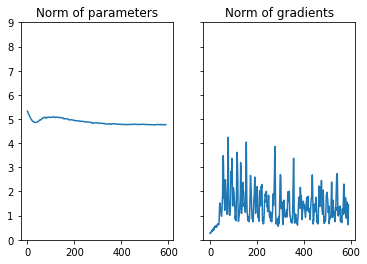

In [9]:
plot_trajectory(trajectory)

In [10]:
test_model(model, testloader, performance=accuracy, loss_fn=loss_fn, device="cpu")

TESTING - loss 31952.34147644043 - performance 0.8459666666666666


(31952.34147644043, 0.8459666666666666)

The L1 norm regularization instead is:[](https://stackoverflow.com/questions/44641976/pytorch-how-to-add-l1-regularizer-to-activations#)

In [11]:
llambda = 0.005

def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device, L1_regularization = True): # note: I've added a generic performance to replace accuracy and the device
    for X, y in dataloader:
        # TRANSFER X AND y TO GPU IF SPECIFIED
        X = X.to(device)
        y = y.to(device)
        # ... like last time
        optimizer.zero_grad() 
        y_hat = model(X)
        
        if L1_regularization:
            params = torch.cat([x.view(-1) for x in model.parameters()])
            l1_regularization = llambda * torch.linalg.norm(params, 1)
            loss = loss_fn(y_hat, y) + l1_regularization
        else:
            loss = loss_fn(y_hat, y)
        
        loss.backward()
        optimizer.step()
        acc = performance(y_hat, y)
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:

            params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
            trajectory["parameters"].append(params_norm)
            trajectory["gradients"].append(gradients_norm)

In [12]:
learn_rate = 0.1
num_epochs = 5

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

trajectory = {"parameters": [], "gradients": []}

In [13]:
train_loss, train_acc, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, trajectory=trajectory, device="cpu")

Training on cpu
Epoch 1 completed. Loss - total: 171455.78059387207 - average: 2.8575963432312013; Performance: 0.33135
Epoch 2 completed. Loss - total: 110691.5297241211 - average: 1.8448588287353516; Performance: 0.6343166666666666
Epoch 3 completed. Loss - total: 89026.77550125122 - average: 1.4837795916875203; Performance: 0.7479333333333333
Epoch 4 completed. Loss - total: 82348.22330474854 - average: 1.3724703884124756; Performance: 0.7633666666666666
Epoch 5 completed. Loss - total: 78060.50213623047 - average: 1.3010083689371745; Performance: 0.7797833333333334


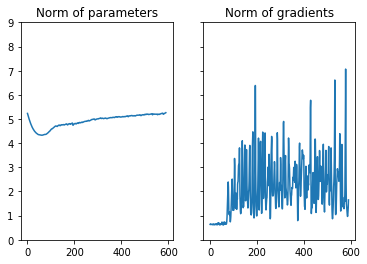

In [14]:
plot_trajectory(trajectory)

In [15]:
test_model(model, testloader, performance=accuracy, loss_fn=loss_fn, device="cpu")

TESTING - loss 32337.58456993103 - performance 0.84205


(32337.58456993103, 0.84205)

## Point 2

A trick which is very often applied is to track the validation performance during training and retain the model with the highest validation performance.
**Note**: it may not be the best strategy as the validation dataset may not be representative of the data manifold (!).
In the main reference for early stopping ([1](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf)), it is indicated as $E_{\text{opt}}$.

**Homework**: implement "early stopping" in the $E_{\text{opt}}$ specification using the test data as validation (since we don't know yet how to create additional `DataLoaders` and operate random splitting).
*Suggestion*: try training for more than 5 epochs, maybe 20-30 total would be fine. Use Colab GPUs in case you want to accelerate training.

**Homework for the bravest ones**: read [1](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf) and try implementing at least one of the techniques there specified (besides $E_{\text{opt}}$, of course). 

In [16]:
learn_rate = 0.1
num_epochs = 30

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

trajectory = {"parameters": [], "gradients": []}

In [28]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device): # note: I've added a generic performance to replace accuracy and the device
    for X, y in dataloader:
        # TRANSFER X AND y TO GPU IF SPECIFIED
        X = X.to(device)
        y = y.to(device)
        # ... like last time
        optimizer.zero_grad() 
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        acc = performance(y_hat, y)
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:

            params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
            trajectory["parameters"].append(params_norm)
            trajectory["gradients"].append(gradients_norm)

def train_model(model, dataloader, testloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None, device=None): # note: I've added a generic performance to replace accuracy and an object where to store the trajectory and the device on which to run our training

    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Training on {device}")

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.to(device)
    model.train()

    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        in_loss, fin_perf = test_model(model, testloader, performance=accuracy, loss_fn=loss_fn, device=None)
        # produce checkpoint dictionary
        if epoch == 0:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "loss": in_loss,
                "performance": fin_perf
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))
        else:
            checkpoint_dict = torch.load(os.path.join(checkpoint_loc, checkpoint_name))
            if fin_perf > checkpoint_dict['performance']:
                checkpoint_dict = {
                    "parameters": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "loss": in_loss,
                    "performance": fin_perf
                }
                torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))

    return loss_meter.sum, performance_meter.avg, trajectory

def test_model(model, dataloader, performance=accuracy, loss_fn=None, device=None):
    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])
    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    print(f"TESTING - loss {fin_loss if fin_loss is not None else '--'} - performance {fin_perf}")
    return fin_loss, fin_perf

In [29]:
folder_save = "data/checkpoints"
#os.makedirs(folder_save, exist_ok=True)
train_loss, train_acc, trajectory = train_model(model, trainloader, testloader, loss_fn, optimizer, num_epochs, checkpoint_loc=folder_save, trajectory=trajectory, device="cpu")

Training on cpu
Epoch 1 completed. Loss - total: 13248.73623085022 - average: 0.22081227051417032; Performance: 0.9334666666666667
TESTING - loss 12192.023822307587 - performance 0.9384333333333333
Epoch 2 completed. Loss - total: 12172.258387565613 - average: 0.20287097312609353; Performance: 0.9381333333333334
TESTING - loss 12093.184962272644 - performance 0.93795
Epoch 3 completed. Loss - total: 11162.41580915451 - average: 0.18604026348590852; Performance: 0.9436833333333333
TESTING - loss 11092.45277929306 - performance 0.9450666666666667
Epoch 4 completed. Loss - total: 10627.577422142029 - average: 0.17712629036903382; Performance: 0.9472833333333334
TESTING - loss 18392.006456375122 - performance 0.90145
Epoch 5 completed. Loss - total: 10061.607825756073 - average: 0.16769346376260122; Performance: 0.9495333333333333
TESTING - loss 10425.58942937851 - performance 0.9477
Epoch 6 completed. Loss - total: 9437.819023609161 - average: 0.15729698372681936; Performance: 0.952866666

The best model is the following:

In [33]:
checkpoint_dict = torch.load(os.path.join(folder_save, "checkpoint.pt"))

model.load_state_dict(checkpoint_dict["parameters"])
optimizer.load_state_dict(checkpoint_dict["optimizer"])

print(f"The best model was generated in epoch {checkpoint_dict['epoch'] + 1} and has a performace of {checkpoint_dict['performance']}")

The best model was generated in epoch 29 and has a performace of 0.97625
